In [6]:
%load_ext autoreload
%autoreload 1

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import Counter, defaultdict, OrderedDict
import multiprocessing as mp
import pickle

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List, Iterable, Callable
import scipy.stats as sps

%aimport ase_matrix
%aimport classification
%aimport toolkit
%aimport util
%aimport workspace_manager

sns.set()

workspace = {}
for data_type in ["scDNA", "scRNA"]:
    workspace.update({ 
        data_type : workspace_manager.WorkspaceManager(
            task_name="ase_to_cnv",
            experiment_info={"data" : data_type},
            verbose=True
        )
    })
    workspace[data_type].load_workspace()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
workspace["scDNA"]

In [9]:
clustering_tag = {
    "scDNA" : "cnv_3",
    "scRNA" : "seurat"
}
filtering_tag = "all"
data = {}
for data_type in ["scDNA", "scRNA"]:
    data[data_type] = {
        data_name :
        util.pickle_load(data_dump)
        for data_name, data_dump in tqdm_notebook(
            workspace[data_type].tmp_data.items(),
            f"{data_type}, loading datasets into RAM"
        )
    }

In [ ]:
"""
This class samples cells from binomial model specified by ASE profiles.
Currently, inference of ASE profile is guided by clustering information:
read counts are added up in each cluster and ASE profiles are computed
for those clusters instead of individual cells.
To sample one cell, the toolkit generates some number of "pseudocells", 
vectors of gene expression counts with a fraction of missing values 
bounded from above by some prespecified constant. Those counts are then 
added up to make up an ASE profile of each sampled cell. 
"""


class KMeansSampler: 
    def __init__(
        self, 
        # dict of phased read counts
        gene_counts_info: Dict[str, pd.DataFrame],
        # dict with a priori clustering information
        clustering_info: Dict[str, pd.DataFrame], 
        # number of jobs to spawn for parallel processing
        n_jobs: int = max(mp.cpu_count() // 2, 1),
        # verbosity flag
        verbose: bool = False
    ): 
        
        assert sorted(gene_counts_info.keys()) == sorted(clustering_info.keys()),\
                "Key sets of gene_counts_info and clustering_info do not match.\n"\
                f"gene_counts_info: {gene_counts_info.keys()}\n"\
                f"clustering_info: {clustering_info.keys()}"
        
        assert "scDNA" in gene_counts_info.keys()
        
        for data_type in clustering_info.keys():
            counts_df = gene_counts_info[data_type]
            clustering_df = clustering_info[data_type]
            
            assert util.is_sorted(counts_df.index)\
                and util.is_sorted(clustering_df.index),\
                f"Index not sorted for {data_type}"
            
            assert "GENE_ID" in counts_df.columns,\
                    f"No GENE_ID column in gene_counts_info for {data_type}"
            
            assert np.all(np.isin(["BARCODE", "LABEL"], 
                                  clustering_df.columns)),\
                    f"BARCODE or LABEL columns not specified for {data_type}"
        
            assert np.all(toolkit.extract_barcodes(counts_df) 
                          == clustering_df.BARCODE),\
                    "No cluster label provided for some of the barcodes"
            
        self._gene_ids = gene_counts_info["scDNA"].GENE_ID
        self._gene_counts_info = gene_counts_info
        self._clustering_info = clustering_info
        
        self._clustered_gene_counts_info = {}
        for data_type, counts_df in gene_counts_info.items():
            self._clustered_gene_counts_info[data_type] =\
                toolkit.aggregate_by_barcode_groups(
                    counts_df,
                    clustering_info[data_type]
                )
        
        self._errstream = sys.stdout if verbose else open(os.devnull, "w+")
        
        assert n_jobs > 0, f"Incorrect n_jobs value: {n_jobs}"
        self._n_jobs = n_jobs

        
    def _sample_pseudocells(
        self, 
        counts_ad_profile: np.ndarray, # ints; n
        counts_dp_profile: np.ndarray, # ints; n
        nan_fraction: float, 
        n_pseudo_per_cell: int
    ): 
        
        # Sample read counts from binomial model.
        # Also take care of the missing values:
        # if no reads map to a specific gene after
        # read counts in each cluster are added up,
        # it should be discarded from the simulation. 
        # Nevertheless, pseudocells should have the
        # same dimensions as the real cells, so the 
        # discarded positions should be added back after sampling.
        
        assert counts_ad_profile.shape == counts_dp_profile.shape,\
                "Count profiles are not aligned"
        
        pseudocell_info = defaultdict(list)
        for i in range(n_pseudo_per_cell):
            old_ad_profile = counts_ad_profile.copy()
            old_dp_profile = counts_dp_profile.copy()

            old_nan_mask = np.isnan(counts_dp_profile)
            old_nan_fraction = old_nan_mask.mean()
            old_nan_count = old_nan_mask.sum()

            if old_nan_fraction < nan_fraction:
                indices = np.arange(counts_dp_profile.size)
                expected_nan_count = np.ceil(
                    nan_fraction * counts_dp_profile.size
                ).astype(int)
                new_nan_pos = np.random.choice(
                    indices[~old_nan_mask],
                    expected_nan_count - old_nan_count,
                    replace=False
                )
                new_nan_mask = np.isin(indices, new_nan_pos)
                counts_dp_profile[new_nan_mask] = np.nan
                counts_ad_profile[new_nan_mask] = np.nan

            ase_profile = counts_ad_profile / counts_dp_profile
            ase_profile[np.isnan(ase_profile)] = 0.5

            n_genes = ase_profile.size
            model = sps.binom(
                n=np.nan_to_num(counts_dp_profile).astype(np.int64),
                p=ase_profile
            )
            pseudocell_info["ad"].append(model.rvs((1, n_genes)).T)
            pseudocell_info["dp"].append(counts_dp_profile)
            
            counts_ad_profile = old_ad_profile
            counts_dp_profile = old_dp_profile
            
        pseudocell_info = {
            counts_type : 
            np.column_stack(pseudocell_list)
            for counts_type, pseudocell_list
            in pseudocell_info.items()
        }
        for counts_type in ["ad", "dp"]:
            pseudocell_mx = pseudocell_info[counts_type]
            assert pseudocell_mx.shape == (n_genes, n_pseudo_per_cell),\
                    "Malformed matrix of pseudocells.\n"\
                    " Expected shape of {}, got {}".format(
                (n_genes, n_pseudo_per_cell),
                pseudocell_mx.shape
            )
        return pseudocell_info # n x n_pseudo_per_cell

    
    def _sample_cell(
        self, 
        counts_ad_profile: np.ndarray, 
        counts_dp_profile: np.ndarray, 
        nan_fraction: float,
        n_pseudo_per_cell: int
    ): 
        
        inferred_gene_counts_info = {
            counts_type :
            np.full_like(counts_dp_profile, np.nan)
            for counts_type in ["ad", "dp"]
        }
        pseudocell_info = self._sample_pseudocells(
            counts_ad_profile.copy(),
            counts_dp_profile.copy(),
            nan_fraction,
            n_pseudo_per_cell
        )
        for counts_type in ["ad", "dp"]:
            notnan_mask = np.invert(
                np.array([
                    np.all(np.isnan(gene_row))
                    for gene_row in pseudocell_info["dp"]
                ])
            )
            inferred_gene_counts_info[counts_type][notnan_mask] = np.nansum(
                pseudocell_info[counts_type][notnan_mask, :], 
                axis=1
            )
        
        return inferred_gene_counts_info
    
    def _process_cluster(self, cluster_info_tuple):
        
        cluster_label, cluster_size = cluster_info_tuple
        sampled_counts_list = []
        
        counts_ad_profile = self._clustered_gene_counts_info["scDNA"]\
                                [f"{cluster_label}_ad"].copy().values
        counts_dp_profile = self._clustered_gene_counts_info["scDNA"]\
                                [f"{cluster_label}_dp"].copy().values

        for _ in tqdm(range(cluster_size)):
            sampled_cell_info = self._sample_cell(
                counts_ad_profile,
                counts_dp_profile, 
                self._nan_fraction,
                self._n_pseudo_per_cell
            )
            sampled_counts_list.append(sampled_cell_info)

        return pd.DataFrame(
            np.column_stack([
                np.column_stack([
                    cell_info[counts_type]
                    for counts_type in ["ad", "dp"]
                ])
                for cell_info in sampled_counts_list
            ]),
            columns=np.hstack([
                [f"{cluster_label}_{j}_ad", 
                 f"{cluster_label}_{j}_dp"]
                for j in range(cluster_size)
            ])
        )        
     
    
    def sample(self, cluster_size_list, nan_fraction, n_pseudo_per_cell): 
        assert 0 <= nan_fraction <= 1,\
            f"nan_fraction outside [0, 1]: {nan_fraction}"
        self._nan_fraction = nan_fraction
        
        assert n_pseudo_per_cell,\
            "Need at least one pseudocell to sample a cell!\n"\
            f"Passed: {n_pseudo_per_cell}"  
        self._n_pseudo_per_cell = n_pseudo_per_cell
        
        sampled_counts_df_list = []
        cluster_label_list = toolkit.extract_barcodes(
            self._clustered_gene_counts_info["scDNA"]
        )
        
        # which loop to parallelize?
        # this one or the nested one?
#         for i, cluster_label in enumerate(tqdm_notebook(
#             cluster_label_list, 
#             desc="generating cells from scDNA clusters"
#         )):
#             sampled_counts_list = []
#             counts_ad_profile = self._clustered_gene_counts_info["scDNA"]\
#                                     [f"{cluster_label}_ad"].copy().values
#             counts_dp_profile = self._clustered_gene_counts_info["scDNA"]\
#                                     [f"{cluster_label}_dp"].copy().values
                
            # this loop can be parallelized 
            # it's body should become a separate function
            # this may require certain restructurization,
            # as only member functions can be parallelized
            # using multiprocessing module
#             for _ in tqdm_notebook(
#                 range(cluster_size_list[i]), 
#                 desc=f"sampling fake cells from cluster {cluster_label}"
#             ):
                
#                 sampled_cell_info = self._sample_cell(
#                     counts_ad_profile,
#                     counts_dp_profile, 
#                     nan_fraction,
#                     n_pseudo_per_cell
#                 )
#                 sampled_counts_list.append(sampled_cell_info)
                
#             sampled_counts_df_list.append(
#                 pd.DataFrame(
#                     np.column_stack([
#                         np.column_stack([
#                             cell_info[counts_type]
#                             for counts_type in ["ad", "dp"]
#                         ])
#                         for cell_info in sampled_counts_list
#                     ]),
#                     columns=np.hstack([
#                         [f"{cluster_label}_{j}_ad", 
#                          f"{cluster_label}_{j}_dp"]
#                         for j in range(n_cells_per_cluster)
#                     ])
#                 )
#             )
        n_jobs = min(cluster_label_list.size, self._n_jobs)
        sampled_counts_df_list = Parallel(n_jobs)(
            delayed(self._process_cluster)(cluster_info_tuple)
            for cluster_info_tuple in
            list(zip(
                cluster_label_list,
                cluster_size_list
            ))
        )
        
        sampled_counts_df = pd.concat(
            sampled_counts_df_list,
            axis=1
        )
        sampled_counts_df.insert(0, "GENE_ID", self._gene_ids)
        return sampled_counts_df

In [151]:
class FixedSizeSampler: 
    def __init__(
        self, 
        # dict of phased read counts
        gene_counts_df: pd.DataFrame,
        # dict with a priori clustering information
        clustering_df: pd.DataFrame, 
        # number of jobs to spawn for parallel processing
        n_jobs: int = max(mp.cpu_count() // 2, 1),
        # verbosity flag
        verbose: bool = False
    ): 
        
        assert util.is_sorted(gene_counts_df.index)\
            and util.is_sorted(clustering_df.index),\
            f"Indices of gene_counts_df and clustering_df are not aligned"

        assert np.all(np.isin(["BARCODE", "LABEL"], 
                              clustering_df.columns)),\
                f"BARCODE or LABEL columns not specified"

        assert np.all(toolkit.extract_barcodes(gene_counts_df) 
                      == clustering_df.BARCODE),\
                "No cluster label provided for some of the barcodes"
        
        self._gene_counts_df = gene_counts_df
        self._clustering_df = clustering_df
        
        self._clustered_gene_counts_df =\
            toolkit.aggregate_by_barcode_groups(
                gene_counts_df,
                clustering_df
            )
        
        self._errstream = sys.stdout if verbose else open(os.devnull, "w+")
        
        assert n_jobs > 0, f"Incorrect n_jobs value: {n_jobs}"
        self._n_jobs = n_jobs

    def sample(self, TOTAL_COUNT_DEPTH: int):
        sampled_count_df_list = []
        cluster_label_list = self._clustering_df["LABEL"].unique()
        for label in tqdm(cluster_label_list, 
                          desc="processing barcode clusters", 
                          file=self._errstream):
            
            barcode_list = self._clustering_df\
                            .query(f"LABEL == {label}")\
                            ["BARCODE"]
            sampled_counts_info = {}
            for barcode in barcode_list: 
                count_profile = {
                    "ad" : self._gene_counts_df[f"{barcode}_ad"],
                    "dp" : self._gene_counts_df[f"{barcode}_dp"]
                }
                p = np.nan_to_num(count_profile["dp"] 
                                  / count_profile["dp"].sum())
                assert np.isclose(np.sum(p), 1.)
                sampled_profile = {
                    "dp" : sps.multinomial.rvs(
                        n=TOTAL_COUNT_DEPTH,
                        p=p
                    ).astype(np.float64)
                }
                assert sampled_profile["dp"].sum() == TOTAL_COUNT_DEPTH
                sampled_profile["dp"][sampled_profile["dp"] == 0] = np.nan
                sampled_profile["ad"] = np.round(
                    sampled_profile["dp"] 
                    * (count_profile["ad"] 
                       / count_profile["dp"])
                )
                sampled_counts_info.update({
                    f"{barcode}_{count_type}" : sampled_counts
                    for count_type, sampled_counts 
                    in sampled_profile.items()
                })
            sampled_count_df_list.append(
                pd.DataFrame(sampled_counts_info)
            )
        result_df = pd.concat(sampled_count_df_list, axis=1)
        result_df["GENE_ID"] = self._gene_counts_df["GENE_ID"]
        return result_df

CPU times: user 26.6 s, sys: 17.6 s, total: 44.2 s
Wall time: 18min 8s


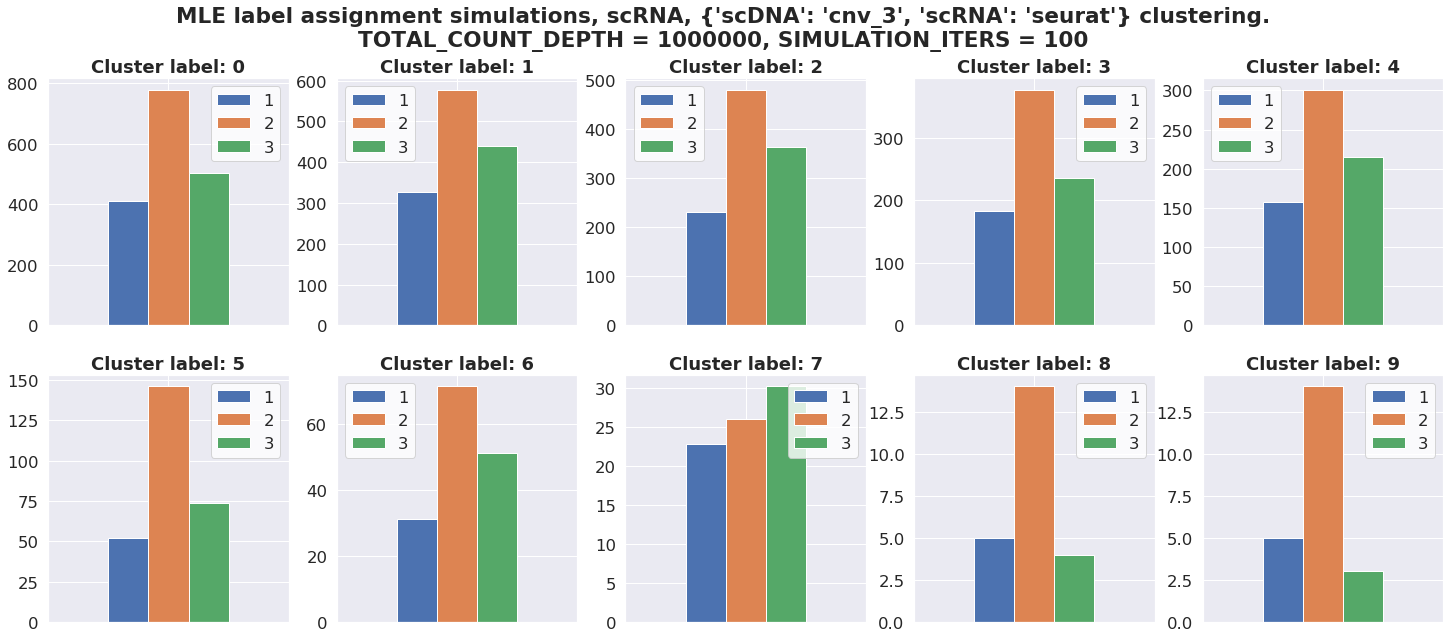

In [194]:
%%time 

from collections import Counter
from sklearn.metrics import balanced_accuracy_score

sns.set(font_scale=1.5)

data_tag = "scRNA"

ase_df = data["scDNA"]["ase"]
clustering_df = data[data_tag]["clustering"]
gene_counts_df = data[data_tag]["gene_counts"]

common_genes = (set(data["scDNA"]["gene_counts"]["GENE_ID"]) 
                & set(gene_counts_df["GENE_ID"]))
ase_df = ase_df[data["scDNA"]["gene_counts"]["GENE_ID"].isin(common_genes)]
gene_counts_df = gene_counts_df[gene_counts_df["GENE_ID"].isin(common_genes)]

SIMULATION_ITERS = 100
cluster_label_list = sorted(clustering_df["LABEL"].unique())
n_clusters = len(cluster_label_list)

ids_of_barcodes_in_clusters = [
    clustering_df\
    .query(f"LABEL == {label}")\
    ["BARCODE"].index.values
    for label in cluster_label_list
]


def simulate_cells(TOTAL_COUNT_DEPTH):
    sampled_counts_df = sampler.sample(TOTAL_COUNT_DEPTH)
    y_pred = clf.predict(
        sampled_counts_df, 
        ase_df
    ) + 1
    cluster_stats = [
        Counter(y_pred[id_list])
        for id_list in ids_of_barcodes_in_clusters
    ]
    return cluster_stats


def process_count_depth(TOTAL_COUNT_DEPTH):
    sampler = FixedSizeSampler(
        gene_counts_df, clustering_df
    )
    clf = classification.AseMleClassifier(
        clustering_df, 
        None
    )
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    fig.suptitle(
        f"MLE label assignment simulations, {data_tag},"
        f" {clustering_tag} clustering.\n"
        f"TOTAL_COUNT_DEPTH = {TOTAL_COUNT_DEPTH},"
        f" SIMULATION_ITERS = {SIMULATION_ITERS}",
        weight="bold"
    )
#     summary_stats = []
#     for _ in tqdm_notebook(range(SIMULATION_ITERS)):
#         sampled_counts_df = sampler.sample(TOTAL_COUNT_DEPTH)
#         y_pred = clf.predict(
#             sampled_counts_df, 
#             ase_df
#         ) + 1
#         cluster_stats = [
#             Counter(y_pred[id_list] for id_list
#                     in ids_of_barcodes_in_clusters)
#         ]
#         summary_stats.append(cluster_stats)
    pool = mp.Pool(min(16, SIMULATION_ITERS))
    summary_stats = np.vstack(pool.map(
        simulate_cells,
        np.full(SIMULATION_ITERS, TOTAL_COUNT_DEPTH)
    )).sum(axis=0)
    pool.close()
    pool.join()
    for i, label in enumerate(cluster_label_list):
        ax = axes[i // 5, i % 5]
        vals = np.array([
            summary_stats[i][cl] 
            for cl in [1, 2, 3]
        ]) / SIMULATION_ITERS
        ax.set_title(f"Cluster label: {label}", weight="bold")
        pd.DataFrame(np.reshape(vals, (1, 3)), index=[0], 
                     columns=[1, 2, 3]).plot(kind="bar", ax=ax)
        ax.set_xticklabels([])
        ax.legend().get_frame().set_facecolor("white")
    fig.savefig(
        f"{workspace[data_tag].img_dir}/simulations/fixed_depth/{data_tag}/"
        f"/{{FT}}[{filtering_tag}]{{CT}}[{clustering_tag['scRNA']}]"
        f"_{TOTAL_COUNT_DEPTH}.png",
        dpi=300
    )

process_count_depth(int(1e6))